In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('NigeriaInflationRates.csv')

In [6]:
print(df.columns.tolist())

['Year', 'Month', 'Inflation_Rate', 'Crude Oil Price', 'Production', 'Crude Oil Export', 'CPI_Food', 'CPI_Energy', 'CPI_Health', 'CPI_Transport', 'CPI_Communication', 'CPI_Education']


In [8]:
import pandas as pd

# 1. Load data
df = pd.read_csv('NigeriaInflationRates.csv') 

# 2. Combine Year and Month into a single Date column
# We add '-01' to signify the first day of the month
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

# 3. Set the Date as the index
df.set_index('Date', inplace=True)

# 4. Sort chronologically (very important for inflation trends)
df.sort_index(inplace=True)

# 5. Drop the old Year/Month columns to keep it clean
df.drop(['Year', 'Month'], axis=1, inplace=True)

print("Data is now indexed by Date!")
print(df.head())

Data is now indexed by Date!
            Inflation_Rate  Crude Oil Price  Production  Crude Oil Export  \
Date                                                                        
2008-01-01             8.6            94.26        2.17              1.72   
2008-02-01             8.0            98.15        2.08              1.63   
2008-03-01             7.8           103.73        2.06              1.61   
2008-04-01             8.2           116.73        1.96              1.51   
2008-05-01             9.7           126.57        2.05              1.60   

             CPI_Food  CPI_Energy  CPI_Health  CPI_Transport  \
Date                                                           
2008-01-01  75.534431   84.612846   83.863139      86.530038   
2008-02-01  75.154185   85.231632   83.365891      88.355236   
2008-03-01  78.242523   83.251516   86.082993      84.376304   
2008-04-01  79.434268   84.348830   89.445332      88.600334   
2008-05-01  80.783677   85.574027   90.540461  

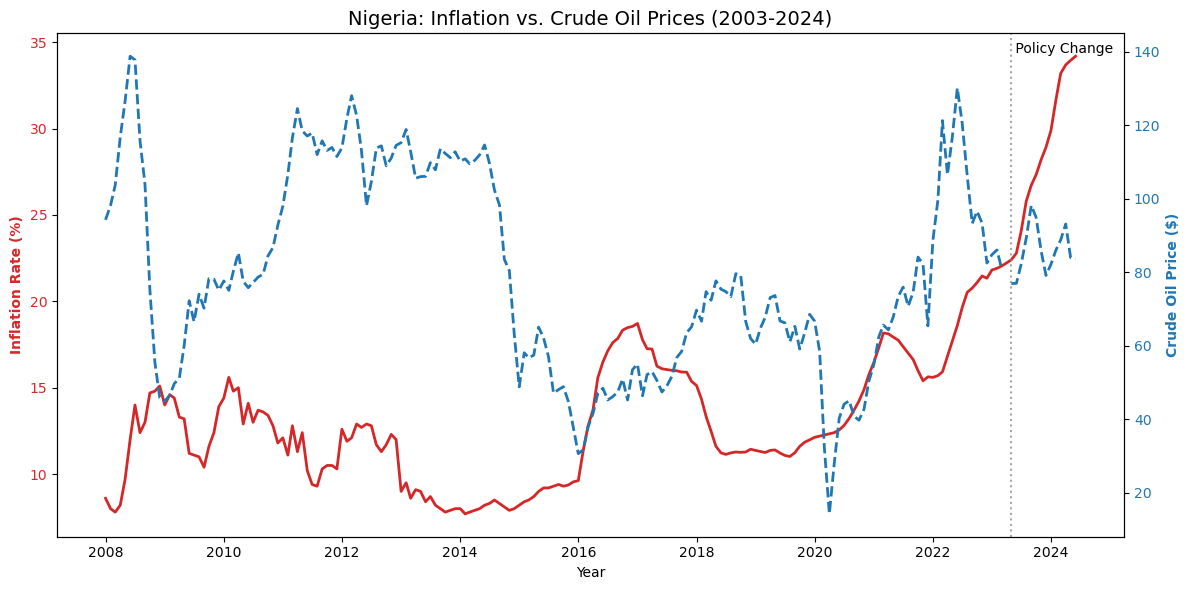

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Inflation on the left axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Inflation Rate (%)', color=color, fontweight='bold')
ax1.plot(df.index, df['Inflation_Rate'], color=color, linewidth=2, label='Inflation')
ax1.tick_params(axis='y', labelcolor=color) # Added quotes around 'y'

# Create a second axis for Oil Price
ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Crude Oil Price ($)', color=color, fontweight='bold')
ax2.plot(df.index, df['Crude Oil Price'], color=color, linewidth=2, linestyle='--', label='Oil Price')
ax2.tick_params(axis='y', labelcolor=color) # Added quotes around 'y'

plt.title('Nigeria: Inflation vs. Crude Oil Prices (2003-2024)', fontsize=14)
fig.tight_layout()
# Adding a vertical line for May 2023 (Major Policy Shift)
plt.axvline(pd.Timestamp('2023-05-01'), color='gray', linestyle=':', alpha=0.7)
plt.text(pd.Timestamp('2023-05-01'), df['Crude Oil Price'].max(), ' Policy Change', rotation=0, verticalalignment='bottom')
plt.show()

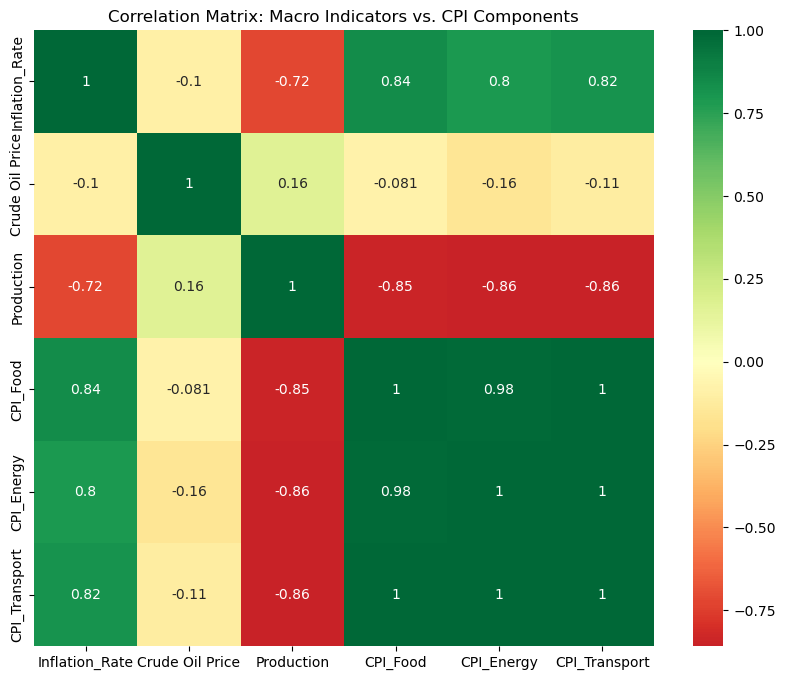

In [12]:
import seaborn as sns

# Select only the economic indicators for the matrix
cols_to_corr = ['Inflation_Rate', 'Crude Oil Price', 'Production', 
                'CPI_Food', 'CPI_Energy', 'CPI_Transport']

corr_matrix = df[cols_to_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation Matrix: Macro Indicators vs. CPI Components')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 1. Create the lag and put it back into the main dataframe to keep things aligned
df['Production_Lag_1'] = df['Production'].shift(1)

# 2. Drop ONLY the rows where we have NaNs (this cleans both X and y at once)
model_data = df[['Production_Lag_1', 'Inflation_Rate']].dropna()

# 3. Define X and y from the cleaned, aligned dataframe
X = model_data[['Production_Lag_1']]
y = model_data['Inflation_Rate']

# 4. Split the data (Now they are both exactly the same length!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Use shuffle=False for Time Series

# 5. Train
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Model R-Squared: {model.score(X_test, y_test):.2f}")
print(f"Prediction for next month: {model.predict(X.tail(1))[0]:.2f}%")

Model R-Squared: -1.00
Prediction for next month: 16.29%


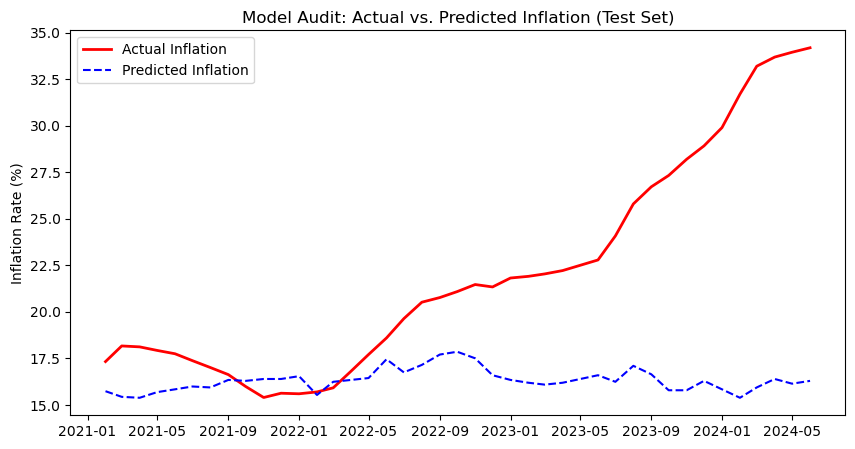

In [15]:
import matplotlib.pyplot as plt

# 1. Generate predictions for the test set
y_pred = model.predict(X_test)

# 2. Plotting the result
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual Inflation', color='red', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Inflation', color='blue', linestyle='--')

plt.title('Model Audit: Actual vs. Predicted Inflation (Test Set)')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

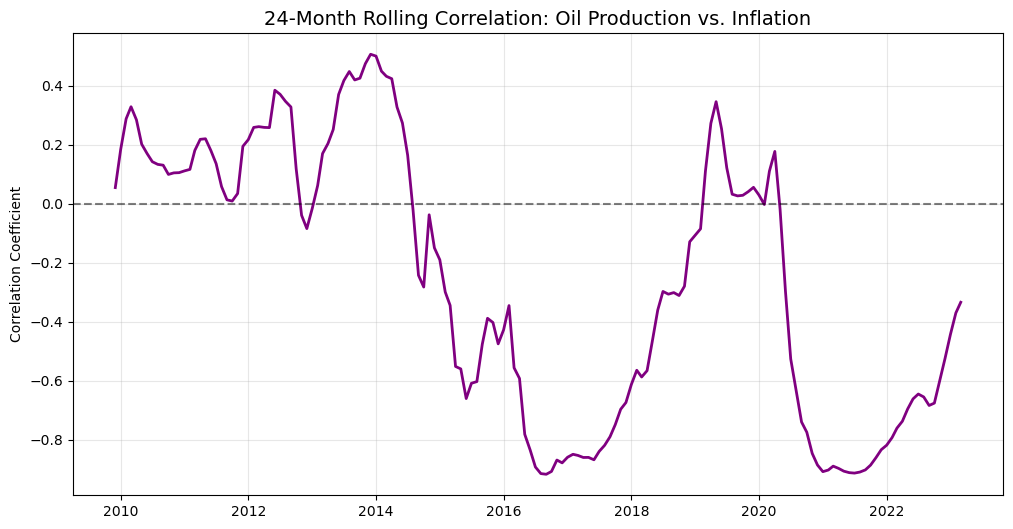

In [16]:
# Calculate correlation over a 24-month sliding window
rolling_corr = df['Inflation_Rate'].rolling(window=24).corr(df['Production'])

plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, color='purple', linewidth=2)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('24-Month Rolling Correlation: Oil Production vs. Inflation', fontsize=14)
plt.ylabel('Correlation Coefficient')
plt.grid(True, alpha=0.3)
plt.show()

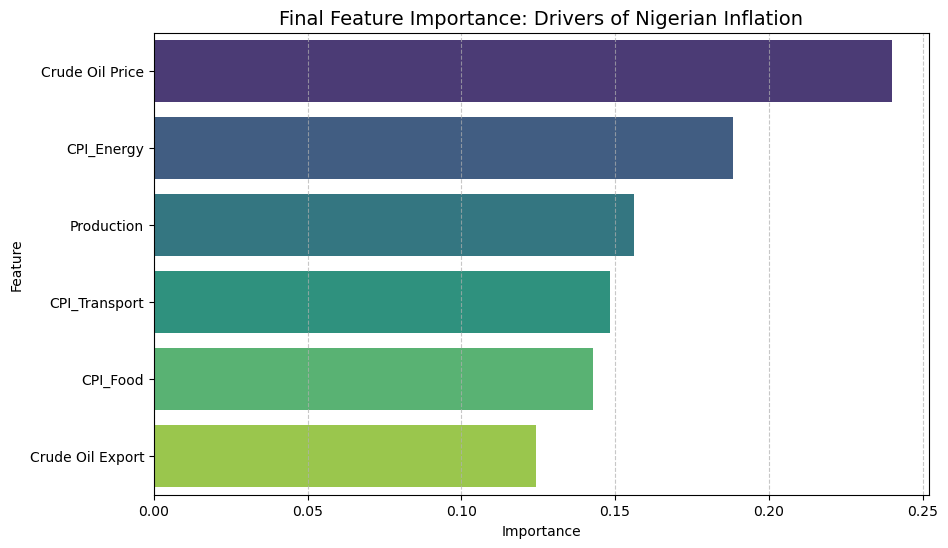

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select your features
features = ['Crude Oil Price', 'Production', 'Crude Oil Export', 
            'CPI_Food', 'CPI_Energy', 'CPI_Transport']

# 2. Create a temporary DataFrame to hold shifted features and the target
# This ensures every row of X matches exactly with the correct y
model_df = df[features].shift(1) # Shift features by 1 month
model_df['Target_Inflation'] = df['Inflation_Rate']

# 3. Drop NaNs (removes the very first row where features are empty)
model_df = model_df.dropna()

# 4. Define X and y from the synced DataFrame
X = model_df[features]
y = model_df['Target_Inflation']

# 5. Split (No shuffling!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 6. Train the Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 7. Generate the Importance Chart
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Updated plotting code to remove the FutureWarning
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    hue='Feature',    # Assigning hue to the y variable
    palette='viridis', 
    legend=False      # Removing the legend since it's redundant here
)
plt.title('Final Feature Importance: Drivers of Nigerian Inflation', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7) # Pro-tip: adds vertical gridlines for readability
plt.show()
